In [16]:
#Importando la biblioteca Pandas
import pandas as pd

#Importando el módulo JSON
import json

# Import requests to fetch data from URL
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io


# import para modelos
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, f1_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc



from sklearn.model_selection import GridSearchCV, StratifiedKFold

import xgboost as xgb
from lightgbm import LGBMClassifier




In [17]:
# DIRECCION:
path = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json'

# Fetch the data from the URL
response = requests.get(path)
data = json.loads(response.text)

# Normalize the JSON data
df_normalized = pd.json_normalize(data)

# Display the first few rows of the normalized DataFrame
display(df_normalized.head())



,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [18]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [19]:
df_normalized.describe()

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly
count,7267.000000,7267.000000,7267.000000
mean,0.162653,32.346498,64.720098
std,0.369074,24.571773,30.129572
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.425000
50%,0.000000,29.000000,70.300000
75%,0.000000,55.000000,89.875000
max,1.000000,72.000000,118.750000


In [20]:
columns_integer = ['customerID', 'customer.tenure', ]
columns_categoricas = ['customer.gender', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup',
                       'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies',
                       'account.Contract', 'account.PaymentMethod' ]

Columns_binarias = ['Churn', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'account.PaperlessBilling' ]
columns_float = ['account.Charges.Monthly', 'account.Charges.Total']

print(len(columns_integer)+len(columns_categoricas)+len(Columns_binarias)+len(columns_float))

21


In [21]:
# Funcion conteo y proporcion de datos
def dist(df,target):
    count= df[target].value_counts(normalize=False)
    prop = df[target].value_counts(normalize=True)*100

    dist = pd.DataFrame({'Freq[N]':count,'Prop[%]':prop.round(3)})
    return dist


In [22]:
# Ver el conteo y la proporción de Class
# columnas_categorias = df.select_dtypes(include='object').columns.tolist()
# print(columnas_categorias)
for i in columns_categoricas:
    print(' '*7,i.upper())
    print(dist(df_normalized,i))
    print("*"*23)


        CUSTOMER.GENDER
                 Freq[N]  Prop[%]
customer.gender                  
Male                3675   50.571
Female              3592   49.429
***********************
        PHONE.MULTIPLELINES
                     Freq[N]  Prop[%]
phone.MultipleLines                  
No                      3495   48.094
Yes                     3065   42.177
No phone service         707    9.729
***********************
        INTERNET.INTERNETSERVICE
                          Freq[N]  Prop[%]
internet.InternetService                  
Fiber optic                  3198   44.007
DSL                          2488   34.237
No                           1581   21.756
***********************
        INTERNET.ONLINESECURITY
                         Freq[N]  Prop[%]
internet.OnlineSecurity                  
No                          3608   49.649
Yes                         2078   28.595
No internet service         1581   21.756
***********************
        INTERNET.ONLINEBACKUP
      

In [24]:
for i in Columns_binarias:
    print(' '*7,i.upper())
    print(dist(df_normalized,i))
    print("*"*23)



        CHURN
       Freq[N]  Prop[%]
Churn                  
No        5174   71.199
Yes       1869   25.719
           224    3.082
***********************
        CUSTOMER.SENIORCITIZEN
                        Freq[N]  Prop[%]
customer.SeniorCitizen                  
0                          6085   83.735
1                          1182   16.265
***********************
        CUSTOMER.PARTNER
                  Freq[N]  Prop[%]
customer.Partner                  
No                   3749   51.589
Yes                  3518   48.411
***********************
        CUSTOMER.DEPENDENTS
                     Freq[N]  Prop[%]
customer.Dependents                  
No                      5086   69.988
Yes                     2181   30.012
***********************
        PHONE.PHONESERVICE
                    Freq[N]  Prop[%]
phone.PhoneService                  
Yes                    6560   90.271
No                      707    9.729
***********************
        ACCOUNT.PAPERLESSBILLIN

In [25]:
# Eliminar filas donde la columna 'Churn' es una cadena vacía
df_cleaned = df_normalized[df_normalized['Churn'] != ''].copy()

# Verificar el número de instancias en el DataFrame limpio
print(f"Número de instancias antes de eliminar: {len(df_normalized)}")
print(f"Número de instancias después de eliminar: {len(df_cleaned)}")

# Mostrar el conteo de valores para la columna 'Churn' en el DataFrame limpio
print("\nConteo de valores para 'Churn' después de eliminar valores vacíos:")
display(df_cleaned['Churn'].value_counts())

Número de instancias antes de eliminar: 7267
Número de instancias después de eliminar: 7043

Conteo de valores para 'Churn' después de eliminar valores vacíos:


,count
Churn,
No,5174
Yes,1869


In [26]:
df_cleaned['customer.SeniorCitizen'] = df_cleaned['customer.SeniorCitizen'].map({0: 'No', 1: 'Yes'})

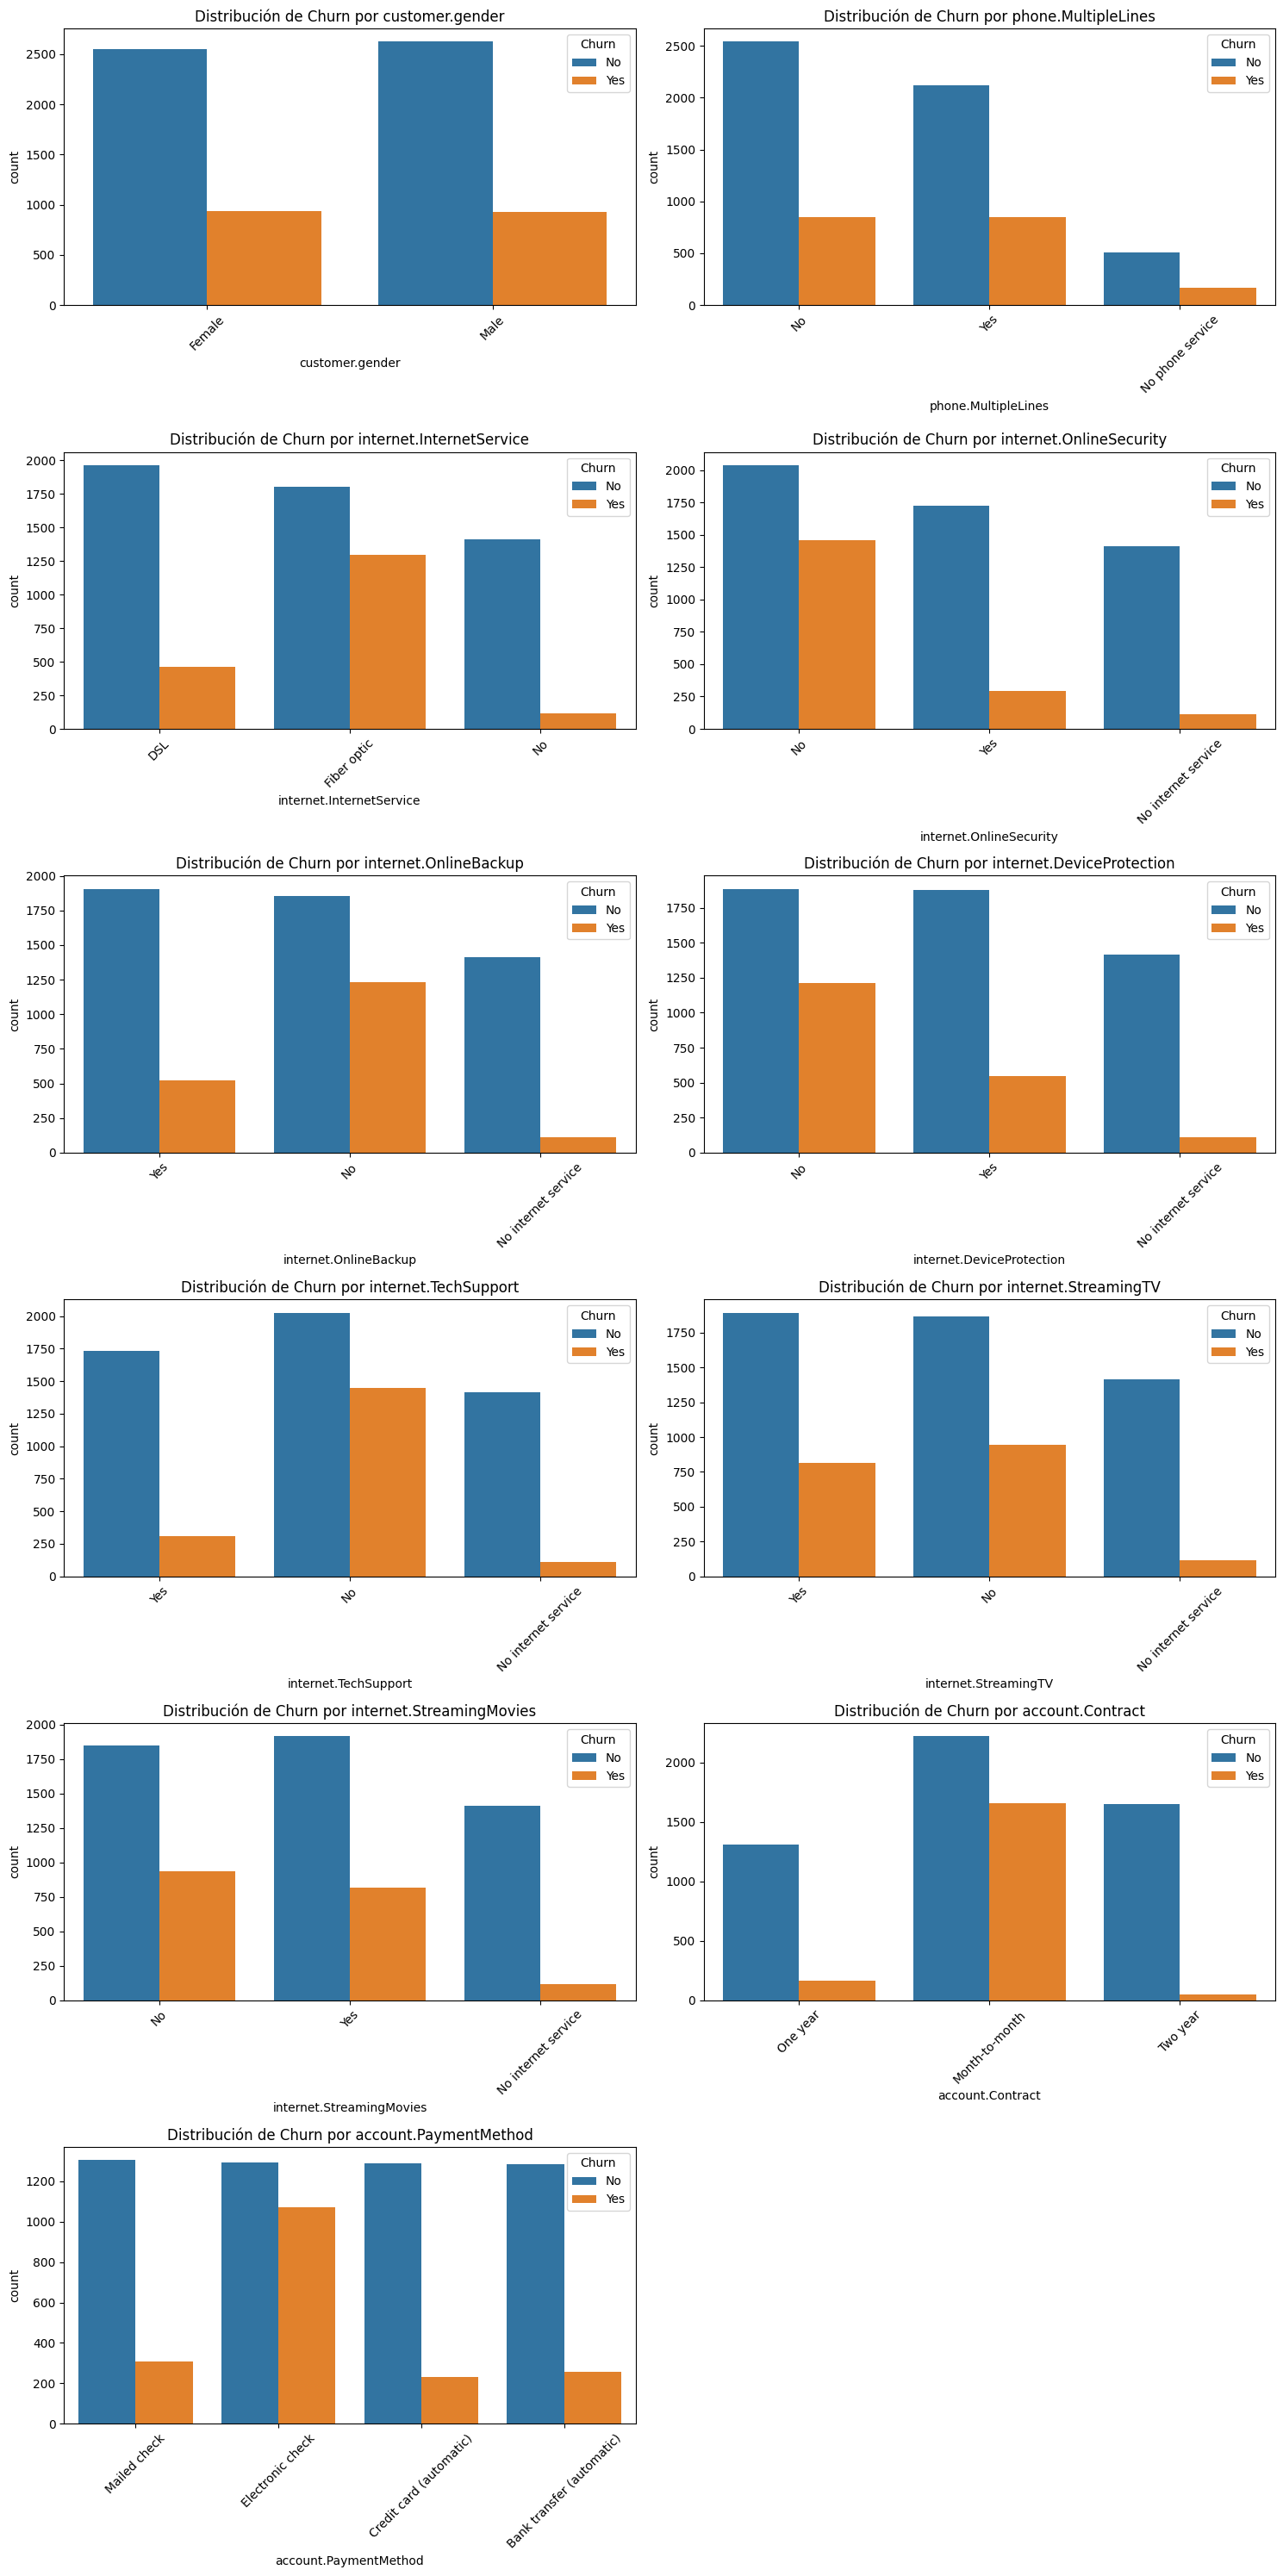

In [27]:
# Se obtiene el listado de variables categóricas (excluyendo 'Churn')
categorical_columns = [col for col in columns_categoricas if col != 'Churn']

# Determinar el número de filas y columnas para la cuadrícula de subplots
n_cols = 2
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Aplanar el array 2D de ejes para facilitar la iteración

# Crear un countplot para cada columna categórica
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df_cleaned, x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f'Distribución de Churn por {col}')
    axes[i].tick_params(axis='x', rotation=45) # Rotar las etiquetas del eje x para mejor legibilidad

# Ocultar cualquier subplot no utilizado
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

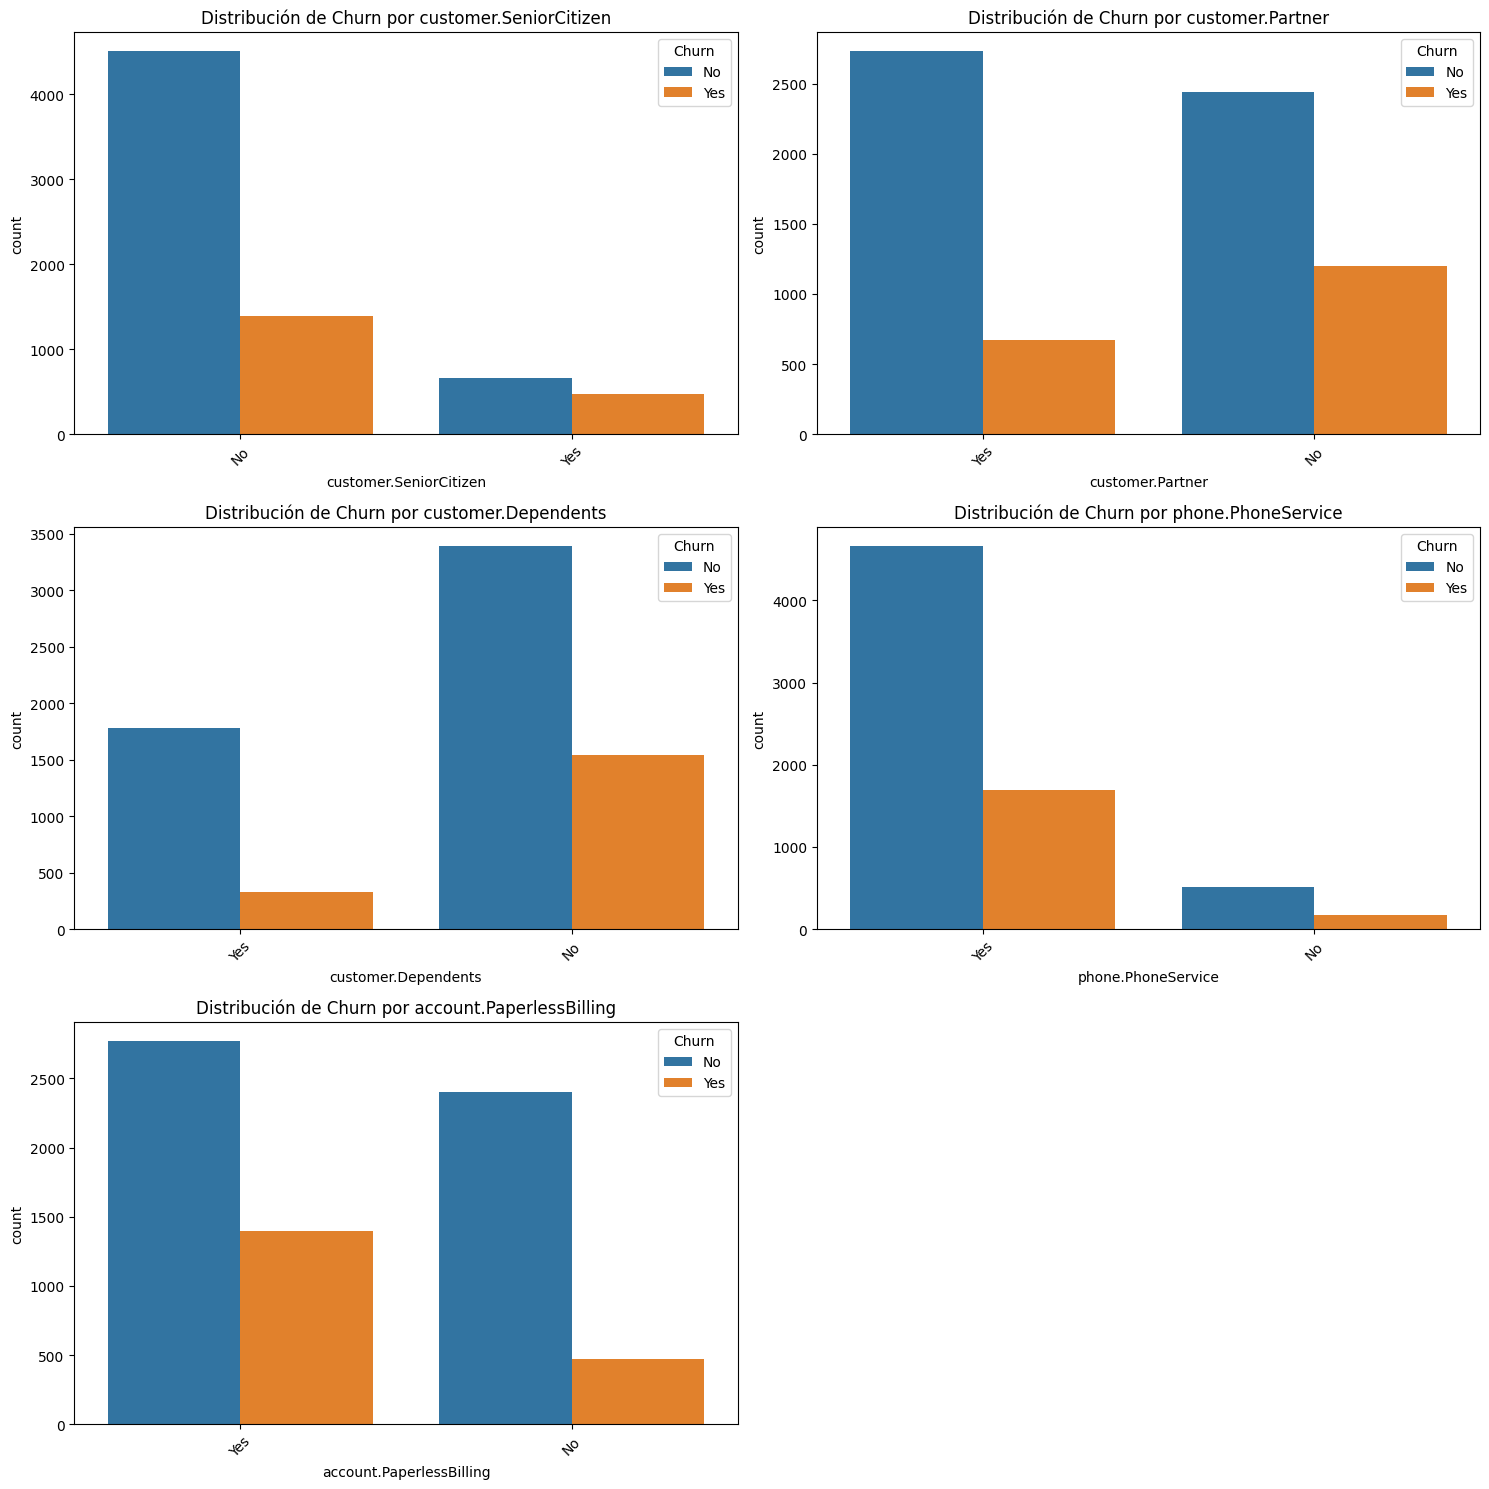

In [28]:
# Obtener la lista de columnas categóricas (excluyendo 'Churn')
categorical_columns = [col for col in Columns_binarias if col != 'Churn']

# Determinar el número de filas y columnas para la cuadrícula de subplots
n_cols = 2
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Aplanar el array 2D de ejes para facilitar la iteración

# Crear un countplot para cada columna categórica
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df_cleaned, x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f'Distribución de Churn por {col}')
    axes[i].tick_params(axis='x', rotation=45) # Rotar las etiquetas del eje x para mejor legibilidad

# Ocultar cualquier subplot no utilizado
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [29]:
# Inspeccionar valores únicos en 'account.Charges.Total' para entender por qué es un objeto
print("Valores únicos en 'account.Charges.Total':")
print(df_cleaned['account.Charges.Total'].unique())

Valores únicos en 'account.Charges.Total':
['593.3' '542.4' '280.85' ... '742.9' '4627.65' '3707.6']


In [35]:
# Convertir 'account.Charges.Total' a numérico, forzando errores
df_cleaned['account.Charges.Total'] = pd.to_numeric(df_cleaned['account.Charges.Total'], errors='coerce')

In [36]:
# Verificar si se introdujeron valores NaN por la coerción
nan_count = df_cleaned['account.Charges.Total'].isnull().sum()
print(f"\nNúmero de valores NaN en 'account.Charges.Total' después de la conversión: {nan_count}")


Número de valores NaN en 'account.Charges.Total' después de la conversión: 11


In [38]:
df_cleaned.dropna(subset=['account.Charges.Total'], inplace=True)

In [39]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   object 
 2   customer.gender            7032 non-null   object 
 3   customer.SeniorCitizen     7032 non-null   object 
 4   customer.Partner           7032 non-null   object 
 5   customer.Dependents        7032 non-null   object 
 6   customer.tenure            7032 non-null   int64  
 7   phone.PhoneService         7032 non-null   object 
 8   phone.MultipleLines        7032 non-null   object 
 9   internet.InternetService   7032 non-null   object 
 10  internet.OnlineSecurity    7032 non-null   object 
 11  internet.OnlineBackup      7032 non-null   object 
 12  internet.DeviceProtection  7032 non-null   object 
 13  internet.TechSupport       7032 non-null   object 
 1

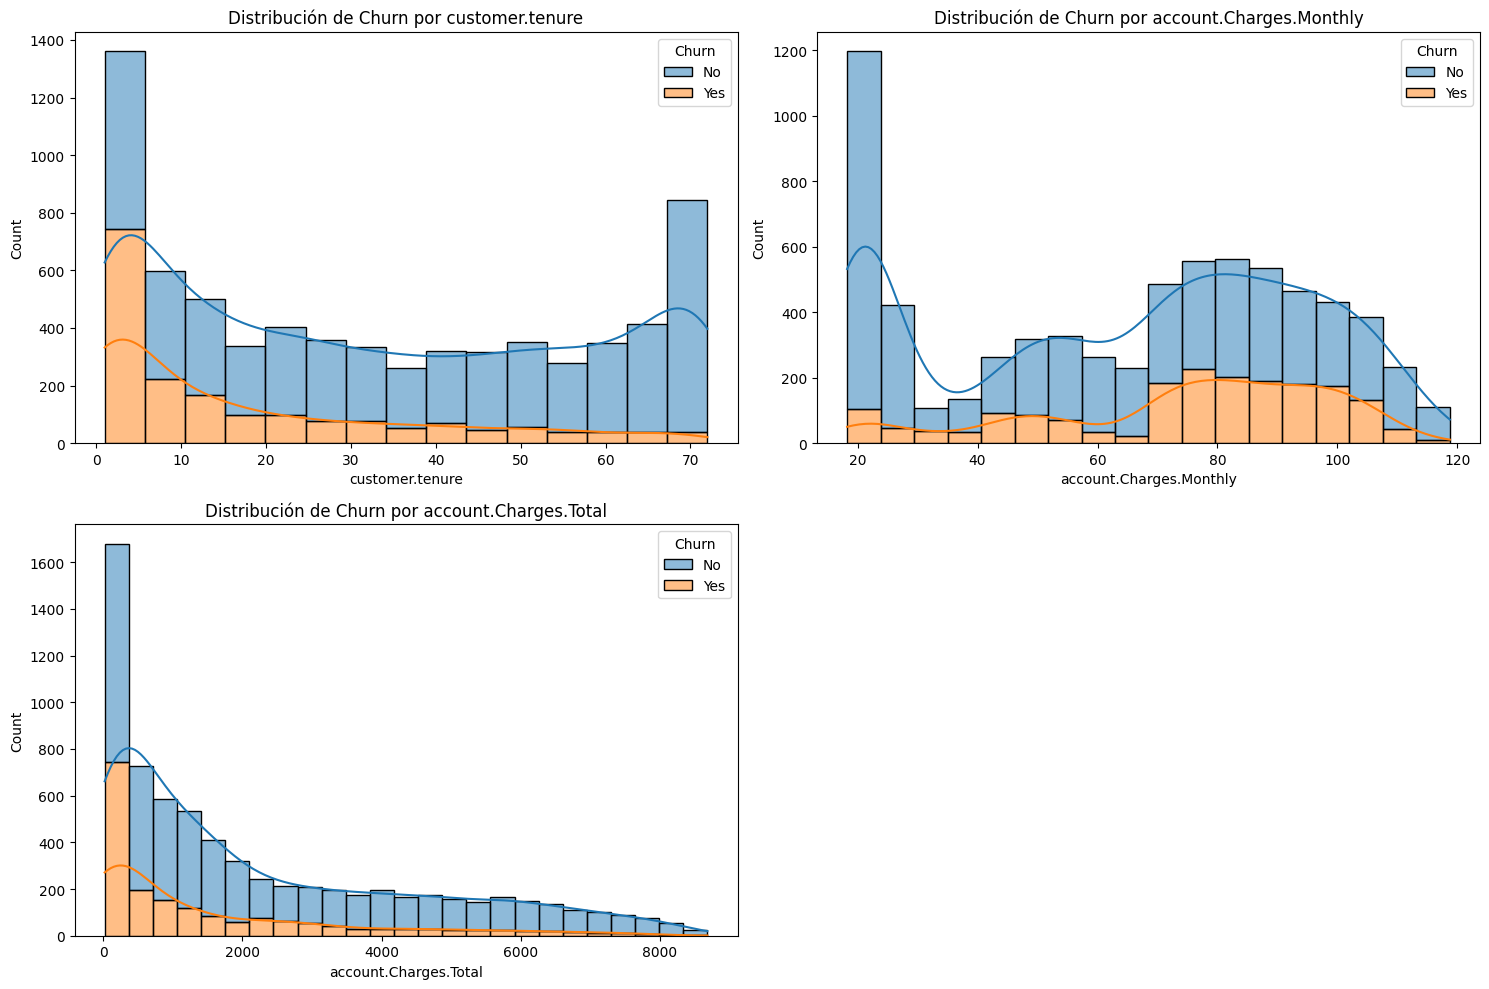

In [40]:
# Combinar columnas numéricas y remover 'customerID'
numerical_columns = [col for col in columns_integer + columns_float if col != 'customerID']

# Determinar el número de filas y columnas para la cuadrícula de subplots
n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Aplanar el array 2D de ejes para facilitar la iteración

# Crear un histograma para cada columna numérica
for i, col in enumerate(numerical_columns):
    sns.histplot(data=df_cleaned, x=col, hue='Churn', multiple='stack', ax=axes[i], kde=True)
    axes[i].set_title(f'Distribución de Churn por {col}')

# Ocultar cualquier subplot no utilizado
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



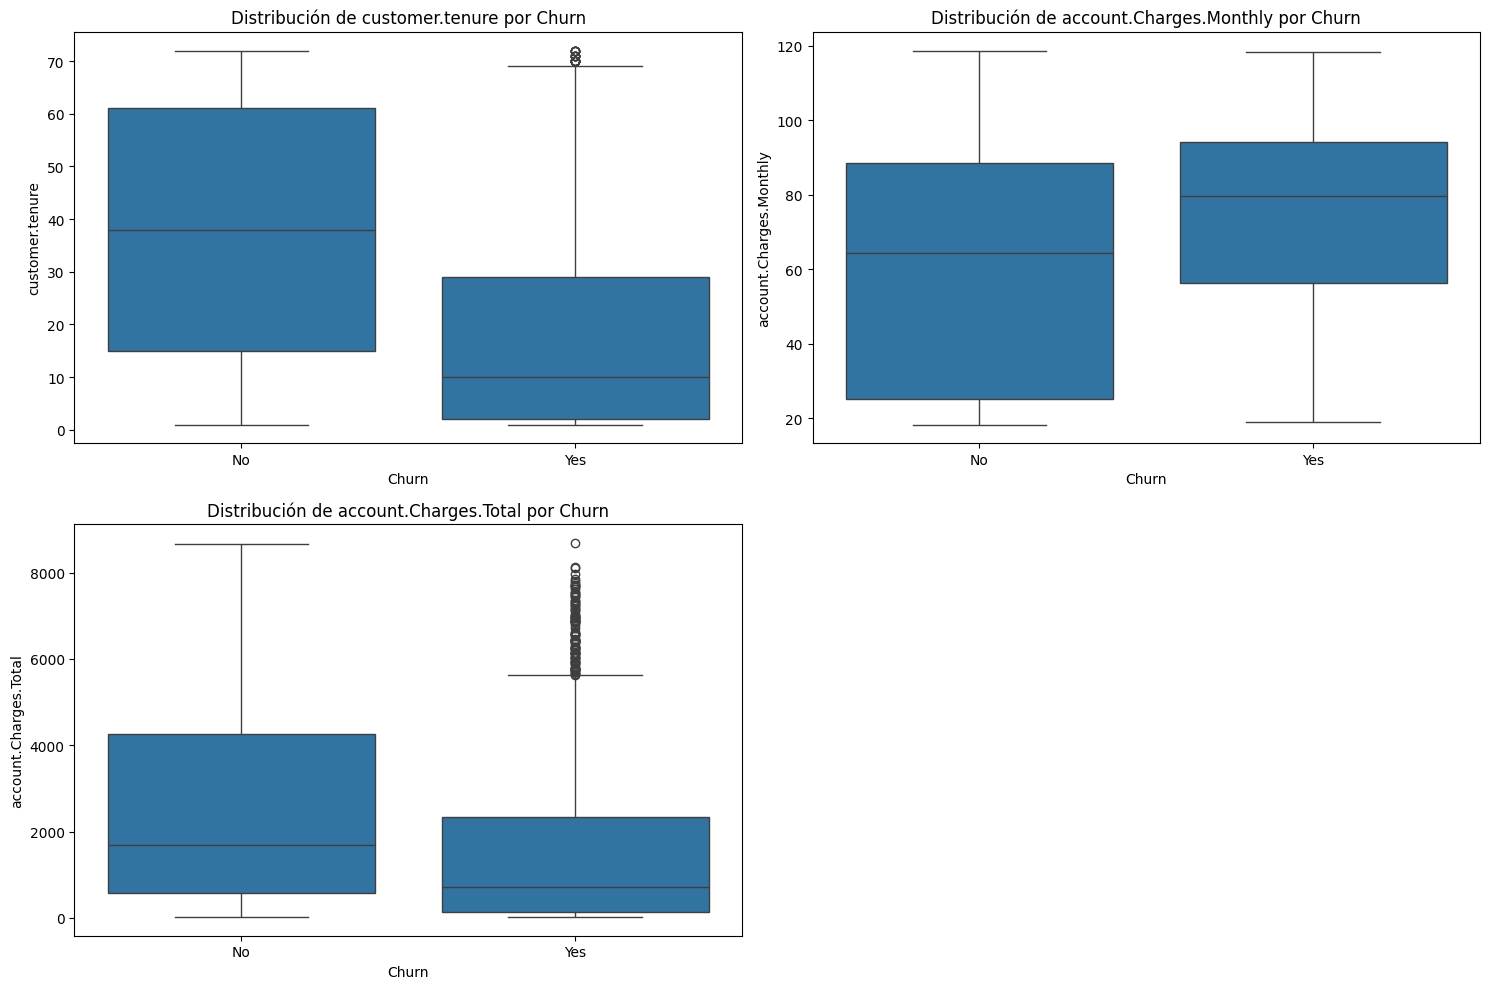

In [41]:
# Combine numerical columns and remove 'customerID'
numerical_columns = [col for col in columns_integer + columns_float if col != 'customerID']

# Determine the number of rows and columns for the subplot grid
n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Create a boxplot for each numerical column
for i, col in enumerate(numerical_columns):
    sns.boxplot(data=df_cleaned, x='Churn', y=col, ax=axes[i])
    axes[i].set_title(f'Distribución de {col} por Churn')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)

# Hide any subplot not used
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




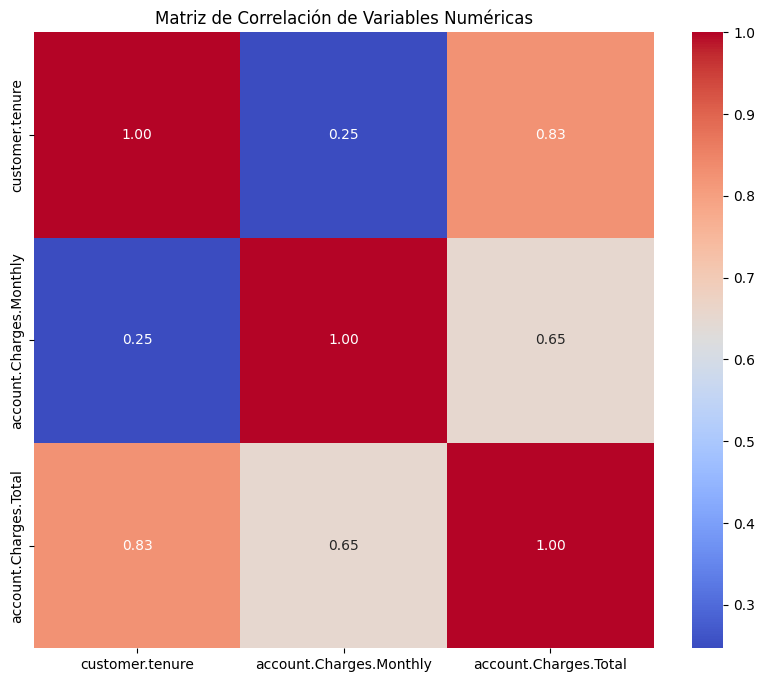

In [42]:
# Calcular la matriz de correlación
# Seleccionar solo las columnas numéricas para el cálculo de correlación
numerical_df = df_cleaned.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

In [43]:
# Crear una nueva columna agrupada para Internet Service
df = df_cleaned.copy()
df['internet_grouped'] = df_cleaned['internet.InternetService'].map({
    'DSL': 'Con Internet',
    'Fiber optic': 'Con Internet',
    'No': 'Sin Internet'
})



In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   object 
 2   customer.gender            7032 non-null   object 
 3   customer.SeniorCitizen     7032 non-null   object 
 4   customer.Partner           7032 non-null   object 
 5   customer.Dependents        7032 non-null   object 
 6   customer.tenure            7032 non-null   int64  
 7   phone.PhoneService         7032 non-null   object 
 8   phone.MultipleLines        7032 non-null   object 
 9   internet.InternetService   7032 non-null   object 
 10  internet.OnlineSecurity    7032 non-null   object 
 11  internet.OnlineBackup      7032 non-null   object 
 12  internet.DeviceProtection  7032 non-null   object 
 13  internet.TechSupport       7032 non-null   object 
 1

In [45]:
# Crea nueva columna 'categoria_servicio'
df['categoria_servicio'] = 'Otros' # Initialize with a default value

# Assign 'Solo Teléfonia' to rows meeting the criteria (only phone, no internet)
df.loc[
    (df['internet.InternetService'] == "No") &
    (df['phone.PhoneService'] == "Yes") & (df['phone.MultipleLines'] == "No"),
    'categoria_servicio'
] = 'Solo Teléfonia'

df.loc[
    (df['internet.InternetService'] == "No") &
    (df['phone.PhoneService'] == "Yes") & (df['phone.MultipleLines'] == "Yes"),
    'categoria_servicio'
] = 'Teléfonia+Multi-lineas'



# Solo Internet si los demas servicios de internet
df.loc[
    (df['internet_grouped'] == "Con Internet") &
    (df['phone.PhoneService'] == "No") &
    (df['internet.OnlineSecurity'] == "No") &
    (df['internet.OnlineBackup'] == "No") &
    (df['internet.DeviceProtection'] == "No") &
    (df['internet.TechSupport'] == "No") &
    (df['internet.StreamingTV'] == "No") &
    (df['internet.StreamingMovies'] == "No"),
    'categoria_servicio'
] = 'Solo Internet'

# Assign 'Solo Serv_Internet' to rows meeting the criteria (only internet, no phone)
df.loc[
    (df['internet_grouped'] == "Con Internet") &
    ((df['phone.PhoneService'] == "No") & (df['categoria_servicio'] != "Solo Internet")),
    'categoria_servicio'
] = 'Solo Serv_Internet'

# Assign 'Ambos Servicios' to rows meeting the criteria (both internet and phone)
df.loc[
    (df['internet_grouped'] == "Con Internet") &
    (df['phone.PhoneService'] == "Yes"),
    'categoria_servicio'
] = 'Ambos Servicios'

# Verify the new column and its distribution
print("Distribución de la nueva columna 'categoria_servicio':")
print(df['categoria_servicio'].value_counts())
print("\n")
print(df['categoria_servicio'].value_counts().sum())

Distribución de la nueva columna 'categoria_servicio':
categoria_servicio
Ambos Servicios           4832
Solo Teléfonia            1180
Solo Serv_Internet         600
Teléfonia+Multi-lineas     340
Solo Internet               80
Name: count, dtype: int64


7032


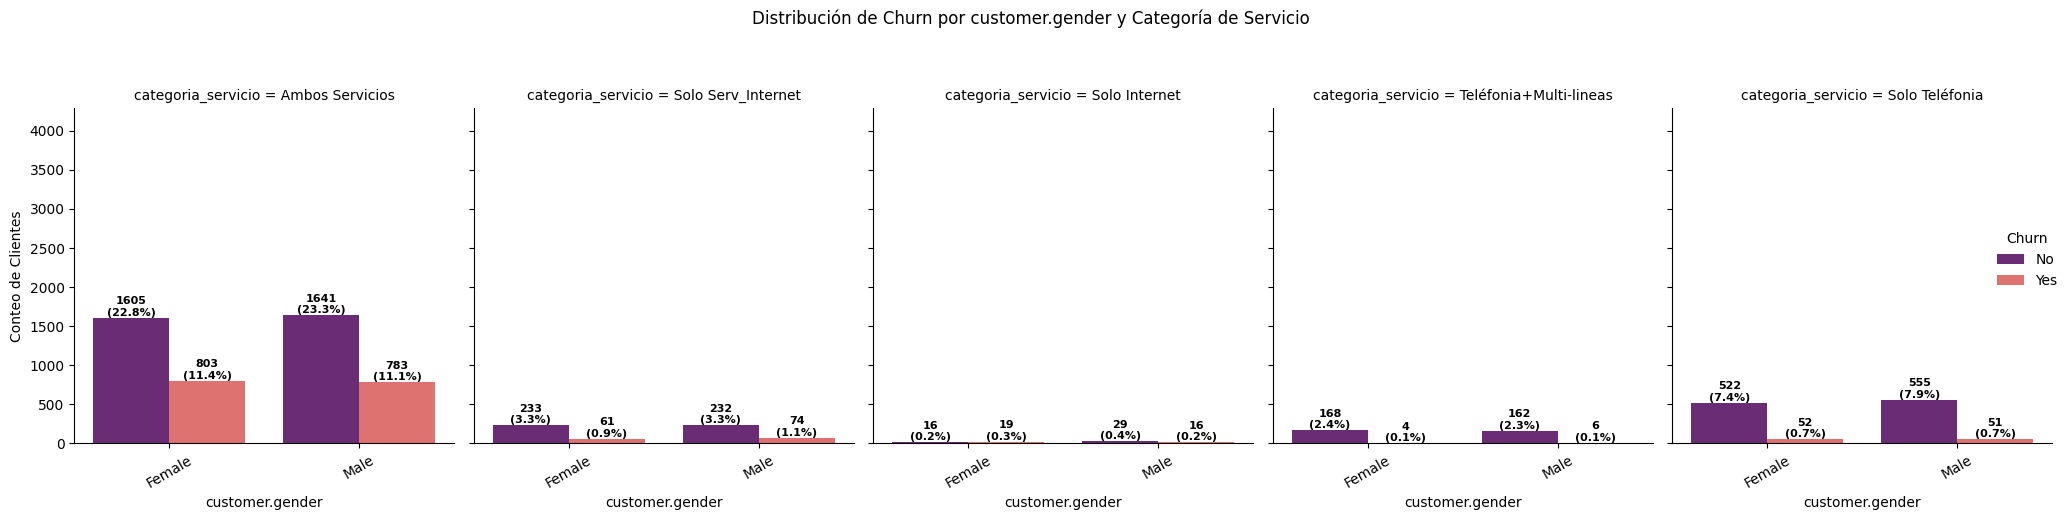

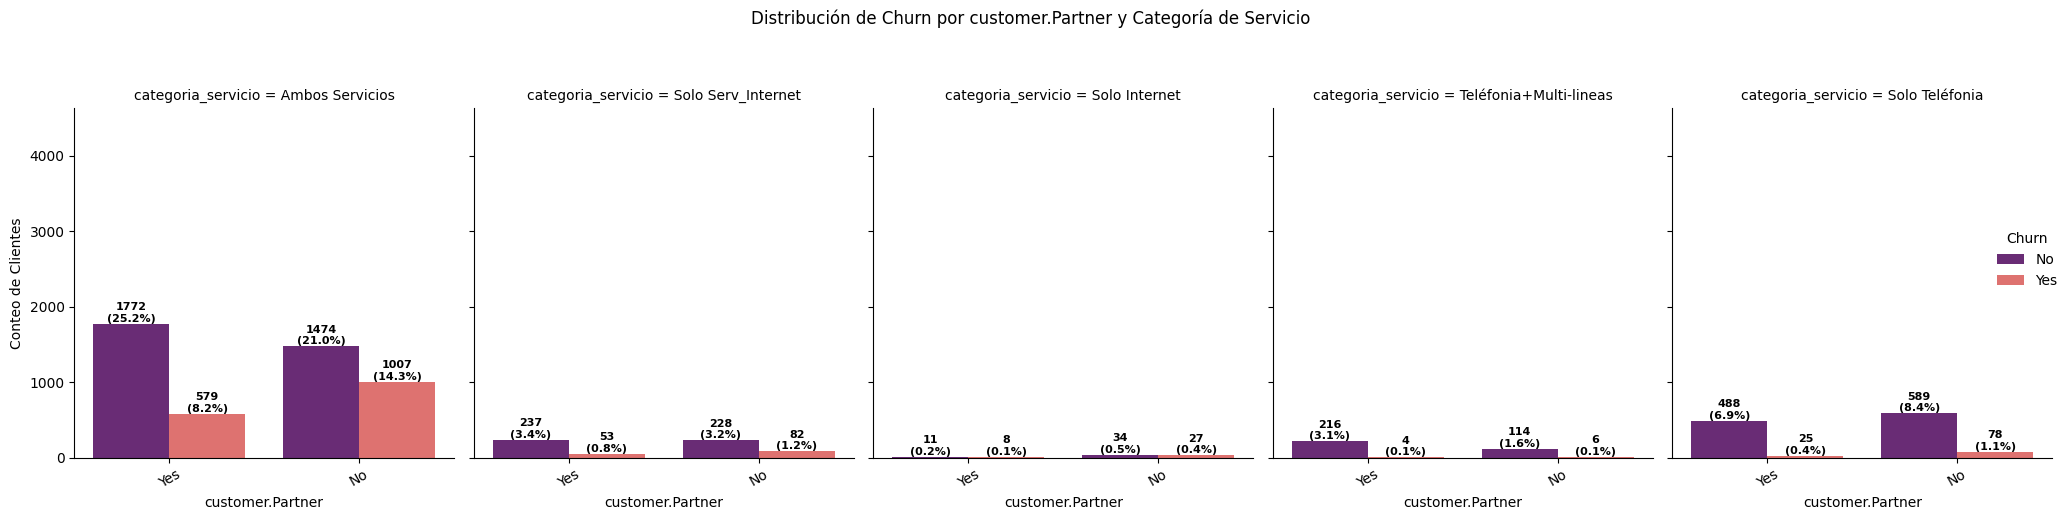

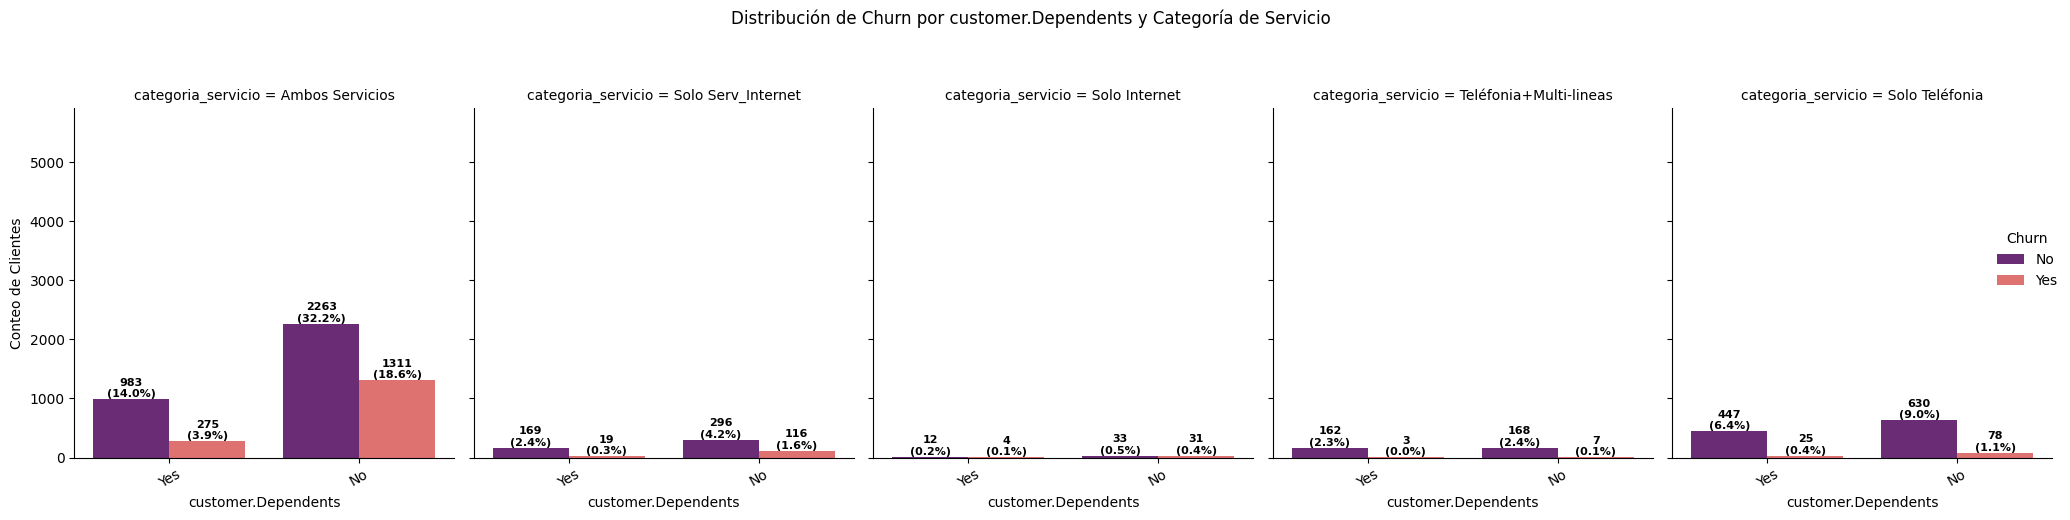

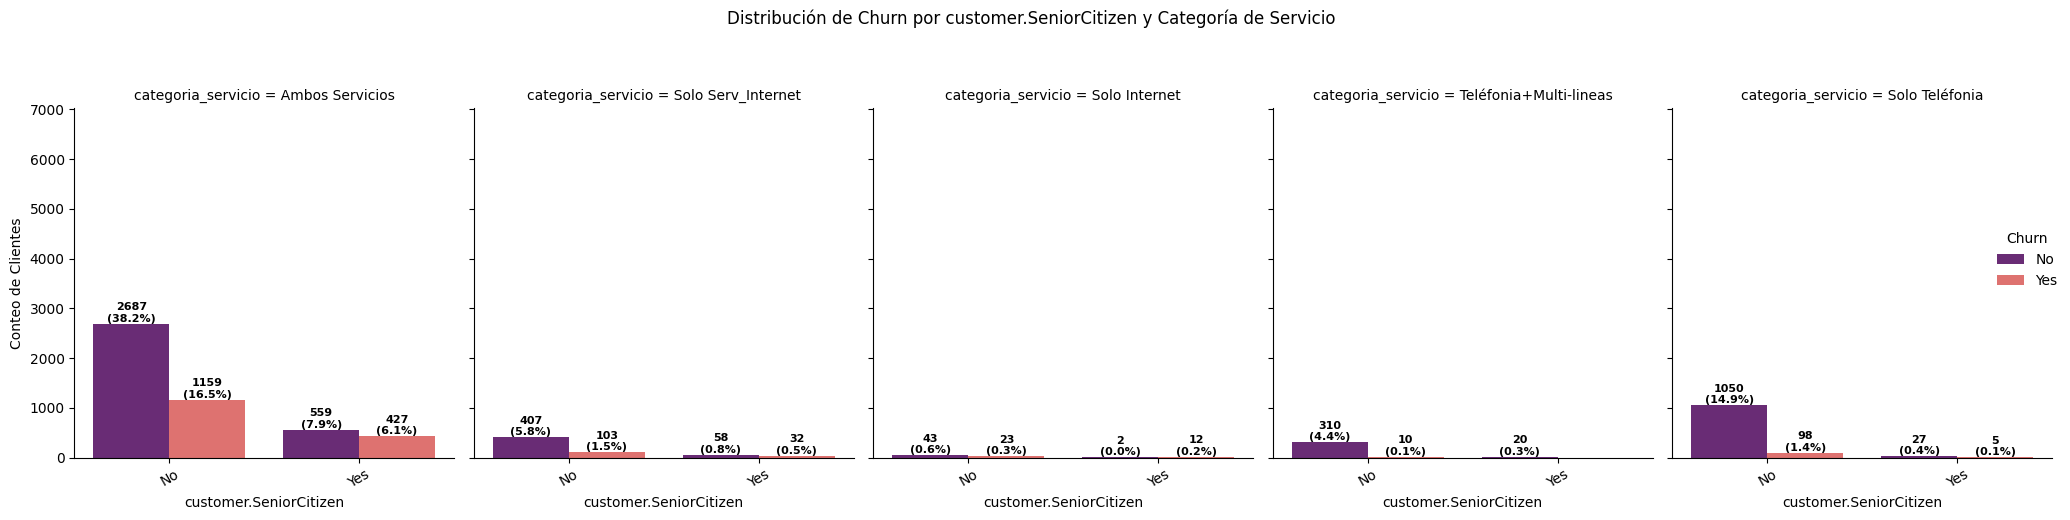

In [46]:
# Lista de columnas demográficas
categoria_demografica = [
    'customer.gender',
    'customer.Partner',
    'customer.Dependents',
    'customer.SeniorCitizen'
]

# Total de registros para calcular porcentajes (usando el df de ejemplo)
total_records = len(df)

# Iteramos sobre cada columna demográfica para crear un gráfico
for col in categoria_demografica:
    # Usamos catplot para crear subplots por 'categoria_servicio'
    g = sns.catplot(
        data= df,
        x=col,
        hue='Churn',
        col='categoria_servicio', # Esto crea los subplots
        kind='count',
        palette='magma',
        height=5,
        aspect=0.8
    )

    # Título general para la figura
    g.fig.suptitle(f'Distribución de Churn por {col} y Categoría de Servicio', y=1.03)
    g.set_xticklabels(rotation=30)
    g.set_xlabels(f'{col}')
    g.set_ylabels('Conteo de Clientes')

    # ── Anotaciones de conteo y porcentaje ───────────────────────────
    # Iteramos sobre cada subplot (ax) en la figura
    for ax in g.axes.flat:
        # Iteramos sobre cada barra (patch) en el subplot
        for patch in ax.patches:
            count = int(patch.get_height())
            if count == 0:
                continue
            pct = 100 * count / total_records
            ax.annotate(
                f'{count}\n({pct:.1f}%)',
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center', va='bottom',
                fontsize=8, fontweight='bold'
            )
        # Ajustar límites del eje Y para dar espacio a las etiquetas
        if ax.get_ylim()[1] > 0: # Solo si hay datos
            y_max = ax.get_ylim()[1]
            ax.set_ylim(0, y_max * 1.20)

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para el suptitle
    plt.show()

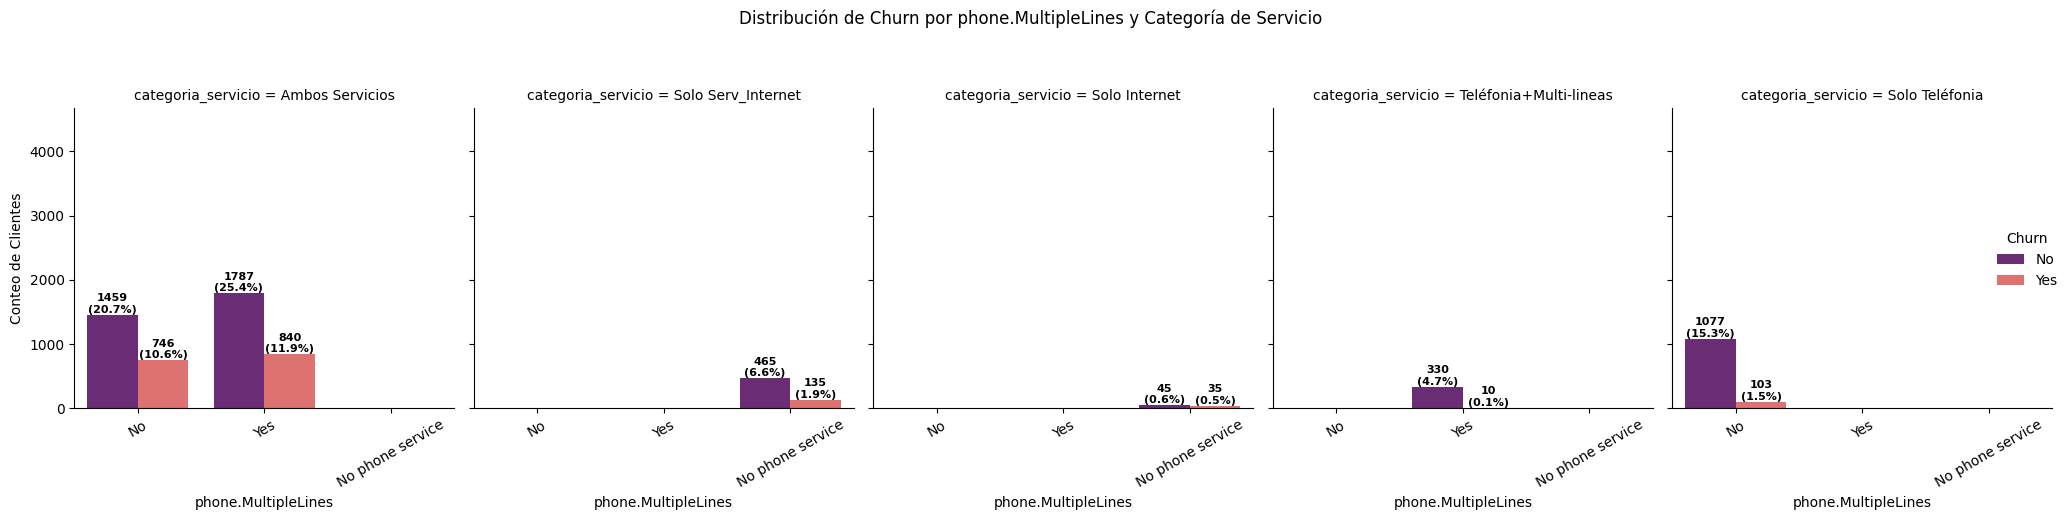

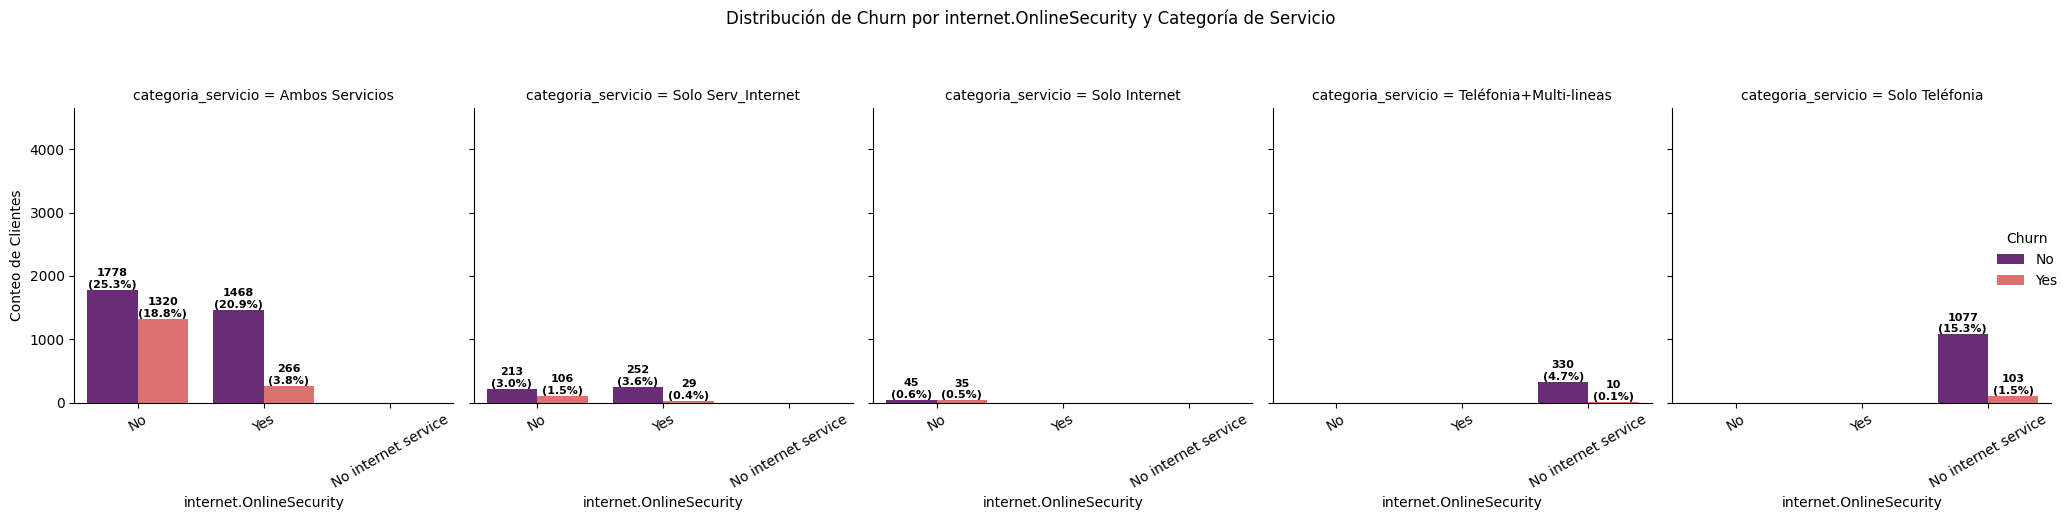

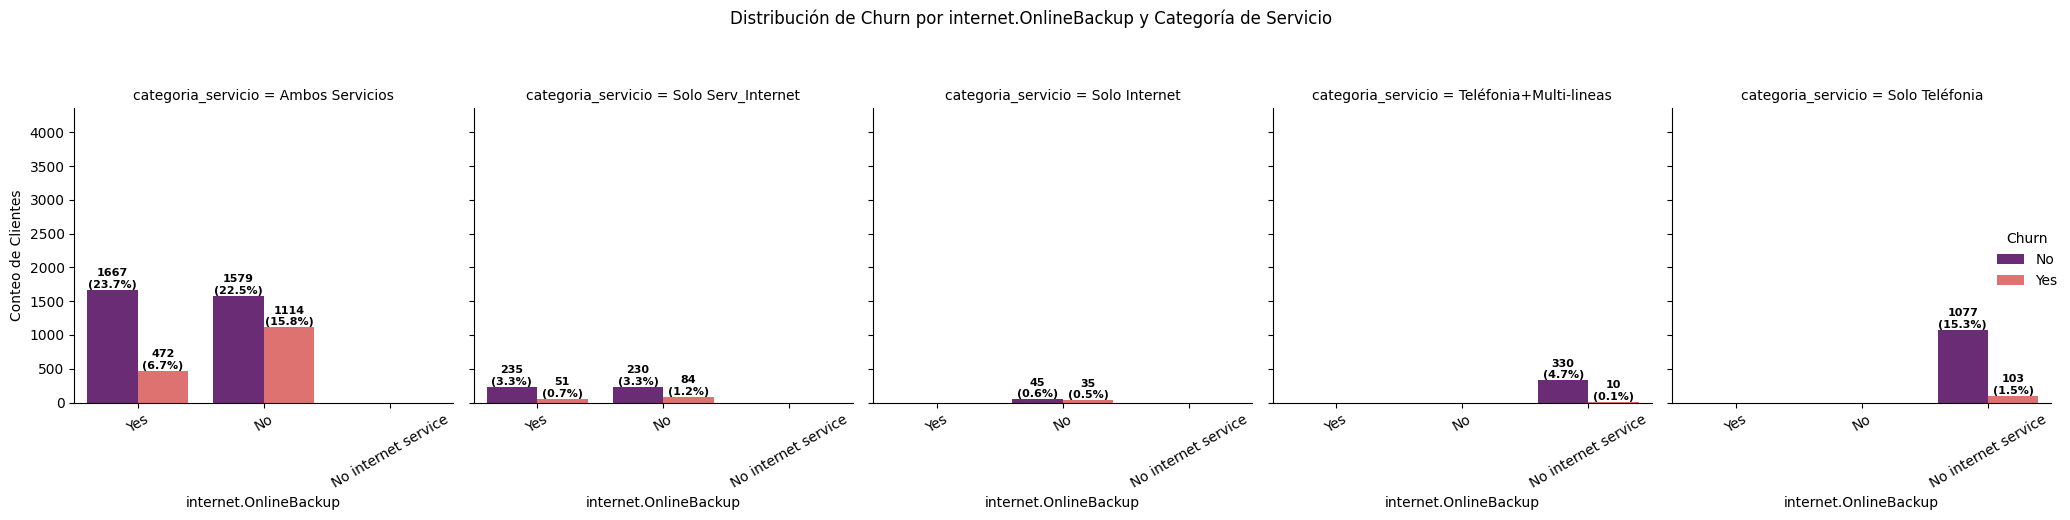

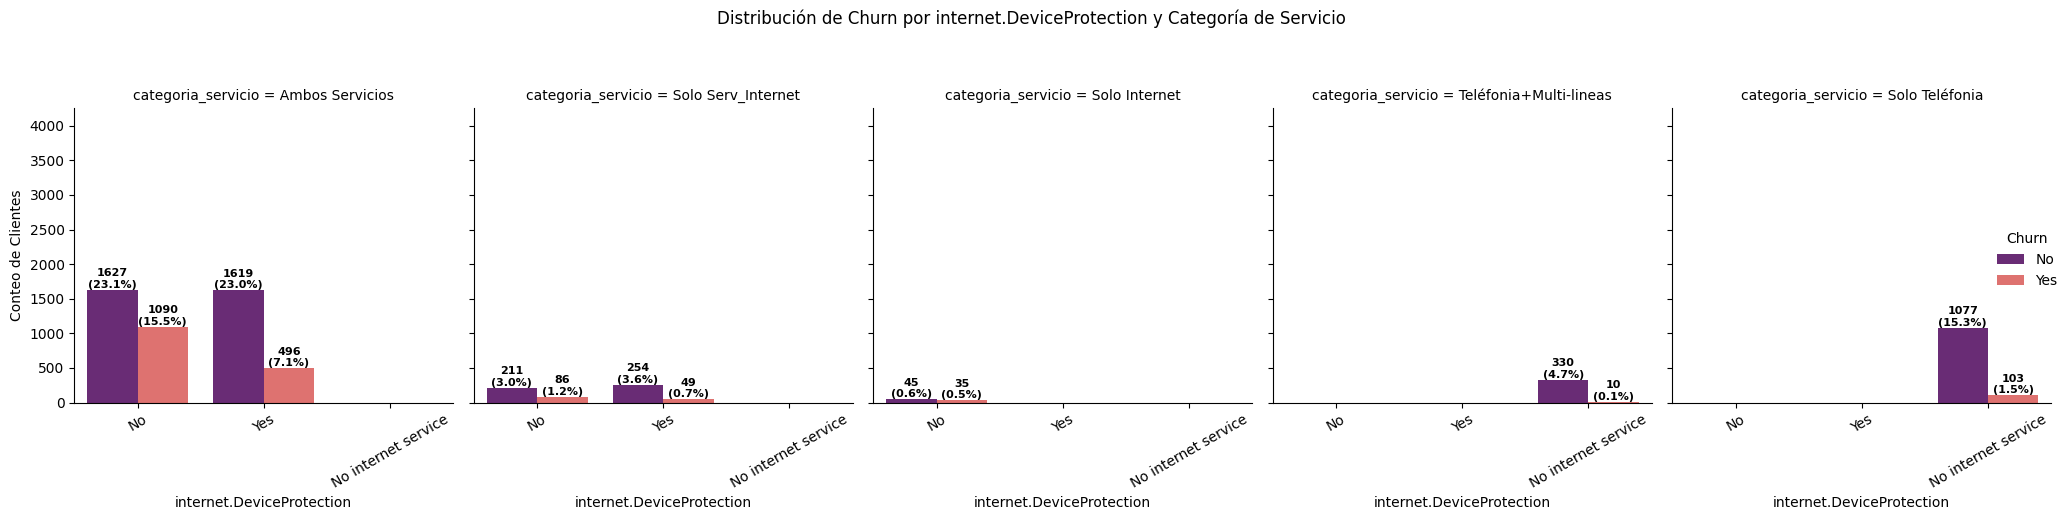

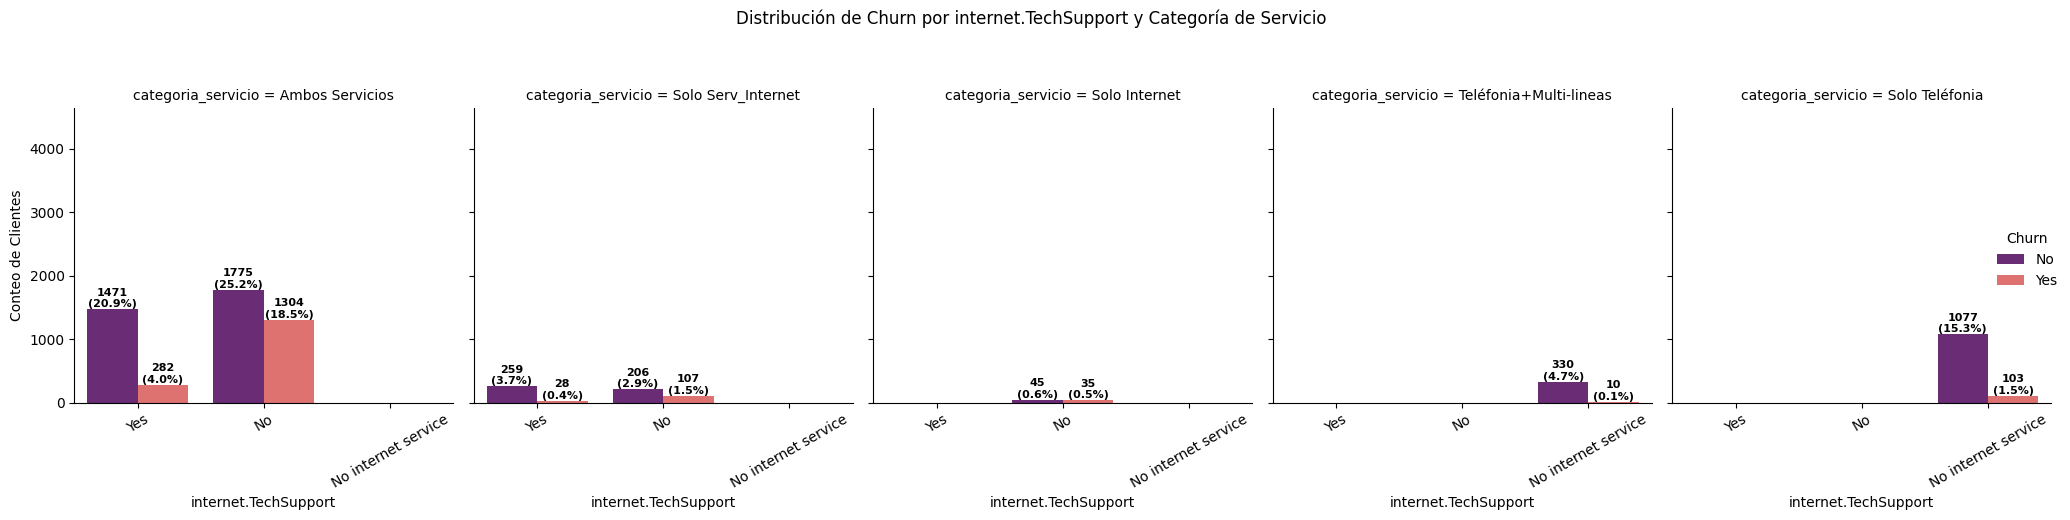

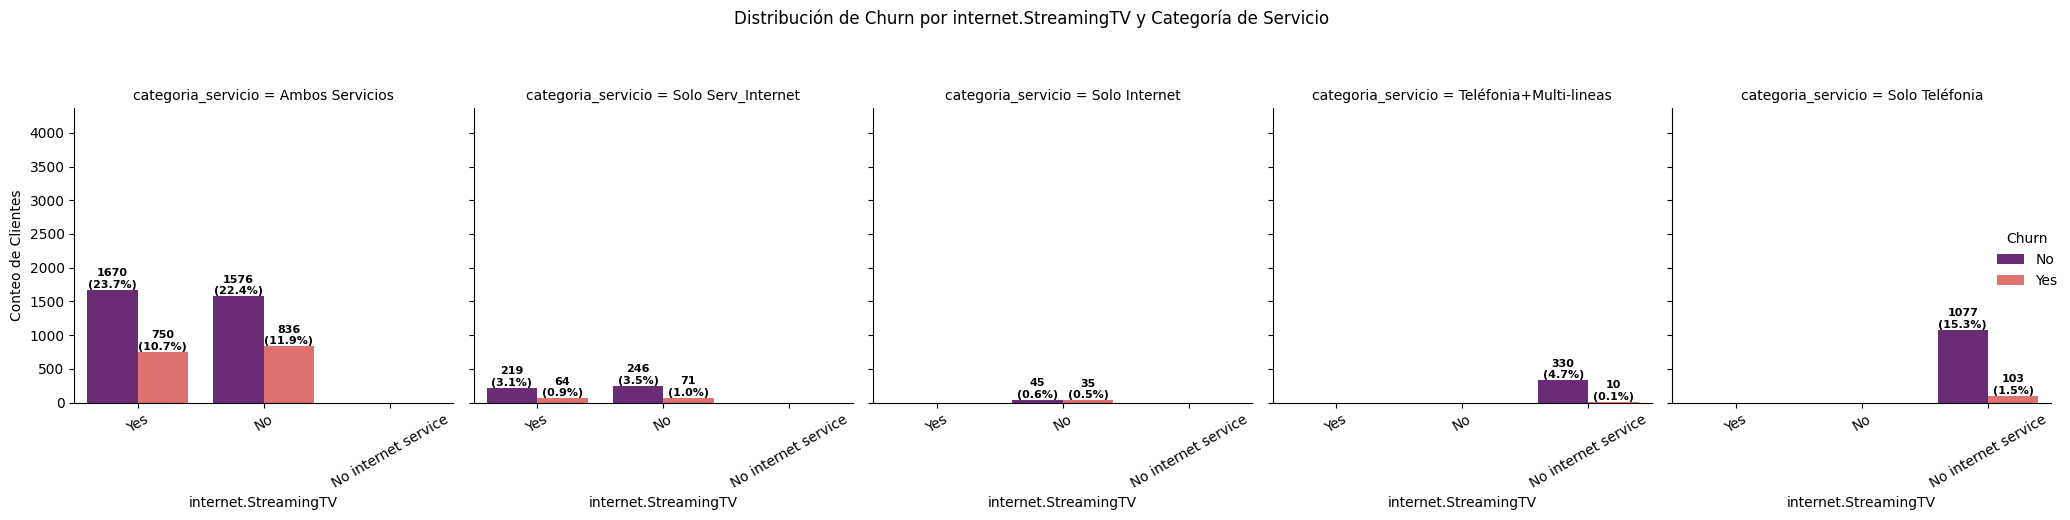

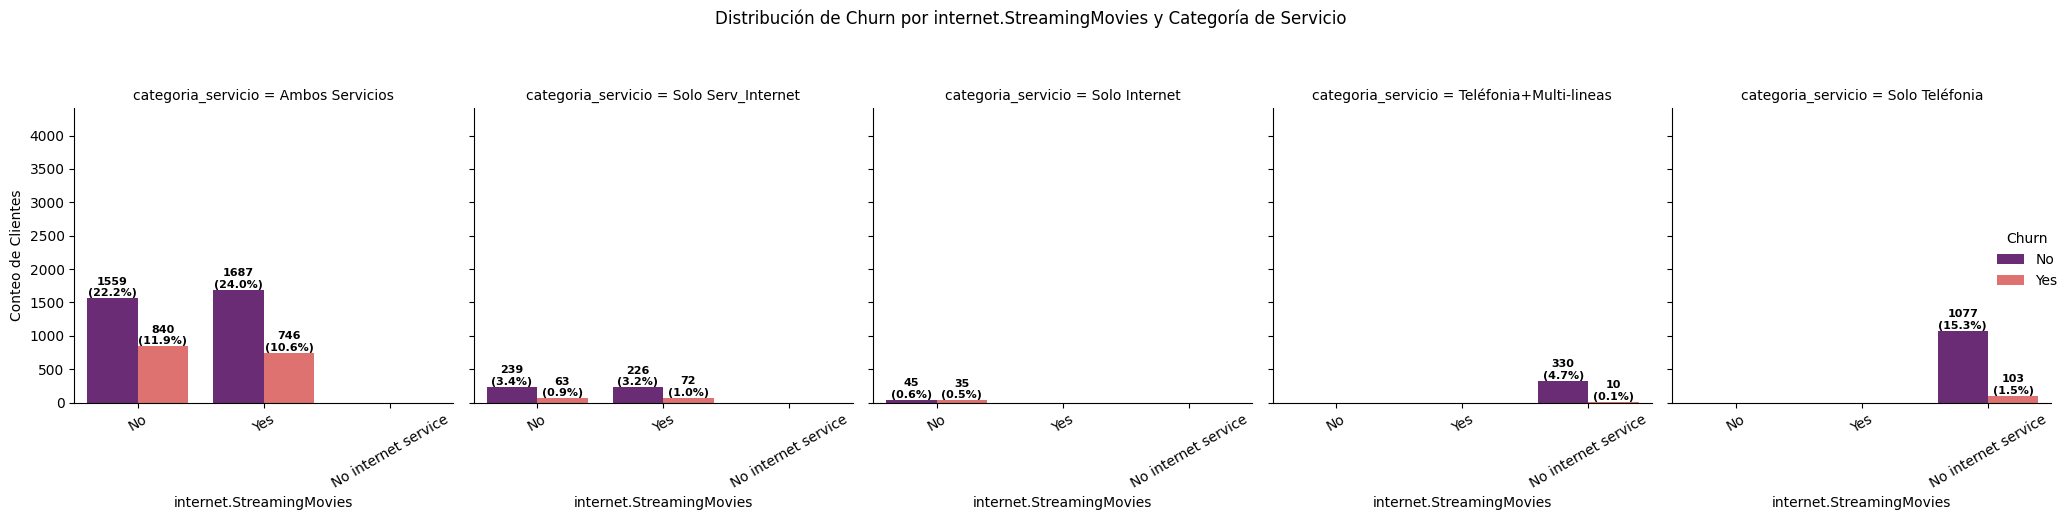

In [47]:
# Lista de columnas demográficas
categoria_servicos = [
    'phone.MultipleLines',
    'internet.OnlineSecurity',
    'internet.OnlineBackup',
    'internet.DeviceProtection',
    'internet.TechSupport',
    'internet.StreamingTV',
    'internet.StreamingMovies'
]

# Total de registros para calcular porcentajes (usando el df de ejemplo)
total_records = len(df)

# Iteramos sobre cada columna demográfica para crear un gráfico
for col in categoria_servicos:
    # Usamos catplot para crear subplots por 'categoria_servicio'
    g = sns.catplot(
        data= df,
        x=col,
        hue='Churn',
        col='categoria_servicio', # Esto crea los subplots
        kind='count',
        palette='magma',
        height=5,
        aspect=0.8
    )

    # Título general para la figura
    g.fig.suptitle(f'Distribución de Churn por {col} y Categoría de Servicio', y=1.03)
    g.set_xticklabels(rotation=30)
    g.set_xlabels(f'{col}')
    g.set_ylabels('Conteo de Clientes')

    # ── Anotaciones de conteo y porcentaje ───────────────────────────
    # Iteramos sobre cada subplot (ax) en la figura
    for ax in g.axes.flat:
        # Iteramos sobre cada barra (patch) en el subplot
        for patch in ax.patches:
            count = int(patch.get_height())
            if count == 0:
                continue
            pct = 100 * count / total_records
            ax.annotate(
                f'{count}\n({pct:.1f}%)',
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center', va='bottom',
                fontsize=8, fontweight='bold'
            )
        # Ajustar límites del eje Y para dar espacio a las etiquetas
        if ax.get_ylim()[1] > 0: # Solo si hay datos
            y_max = ax.get_ylim()[1]
            ax.set_ylim(0, y_max * 1.20)

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para el suptitle
    plt.show()

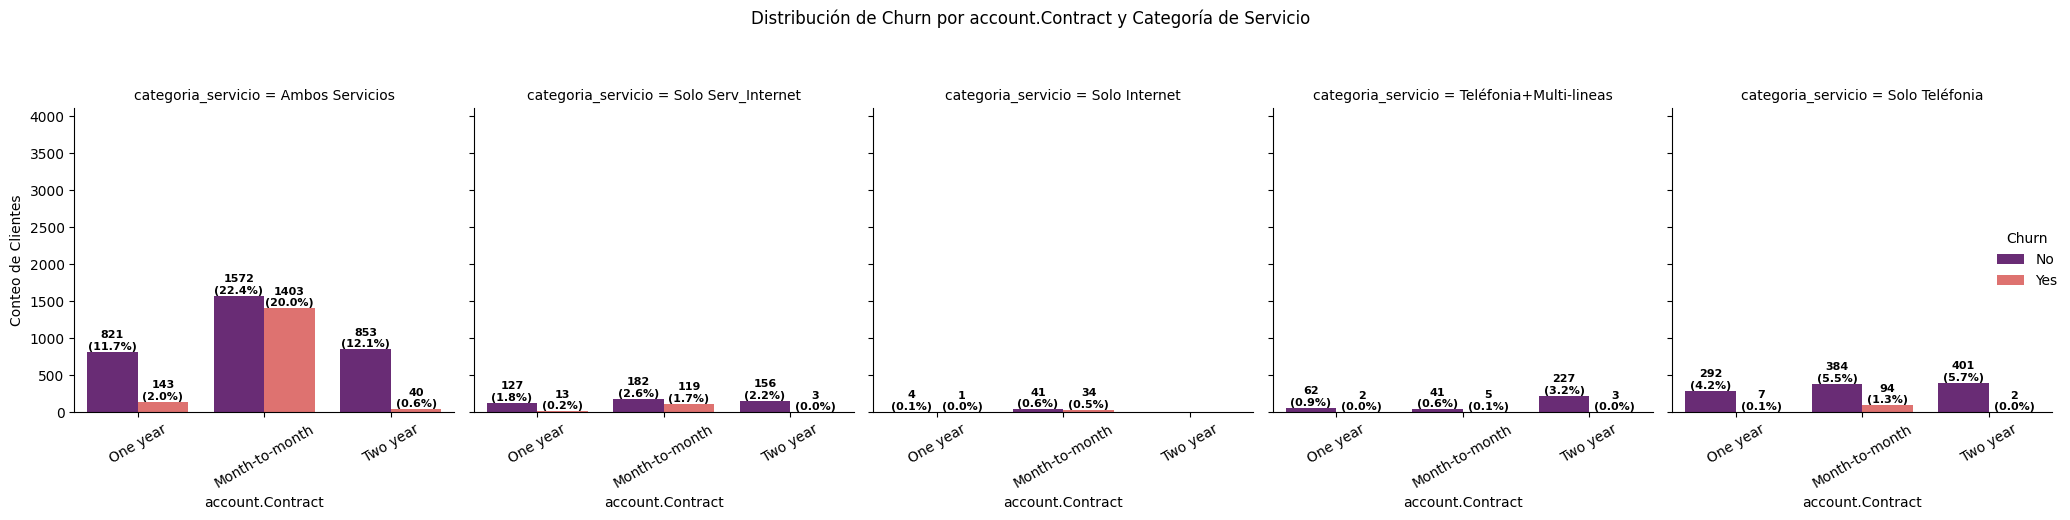

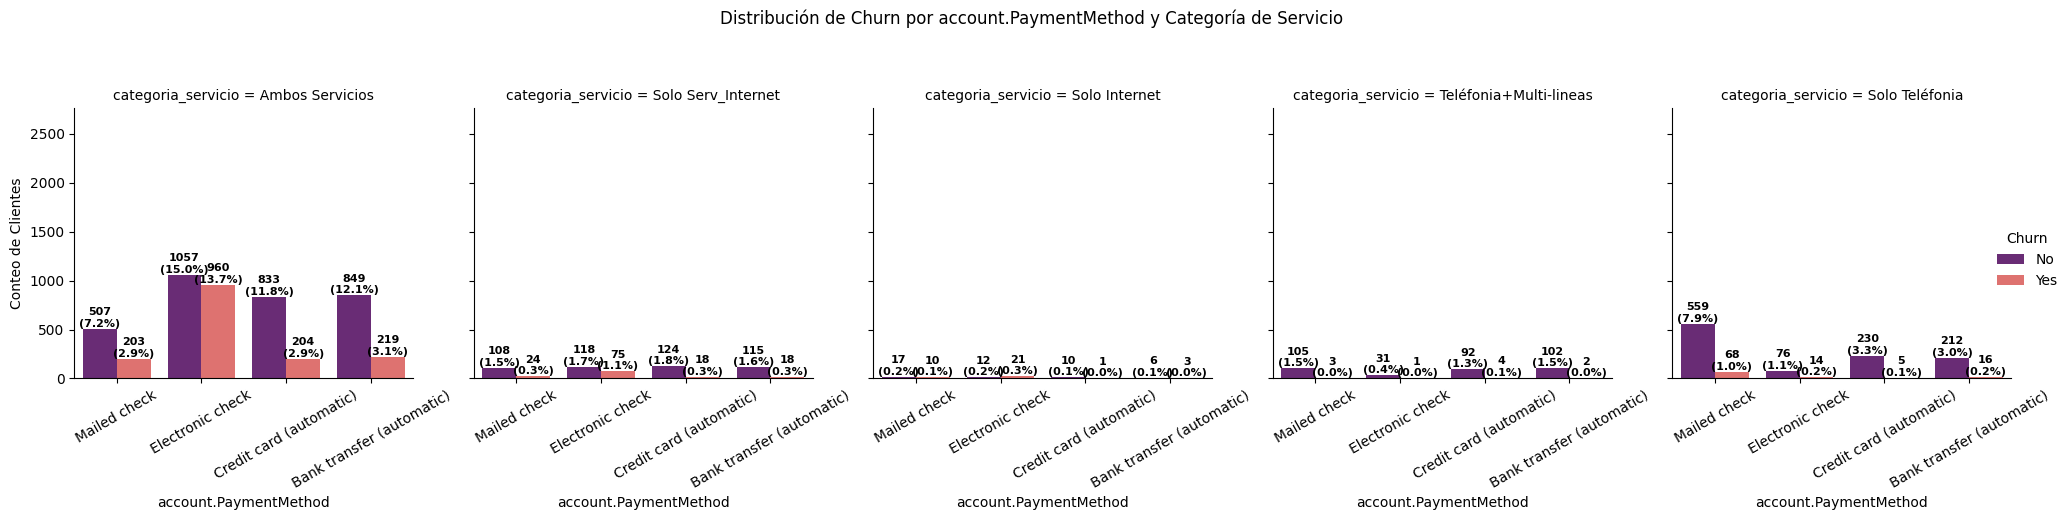

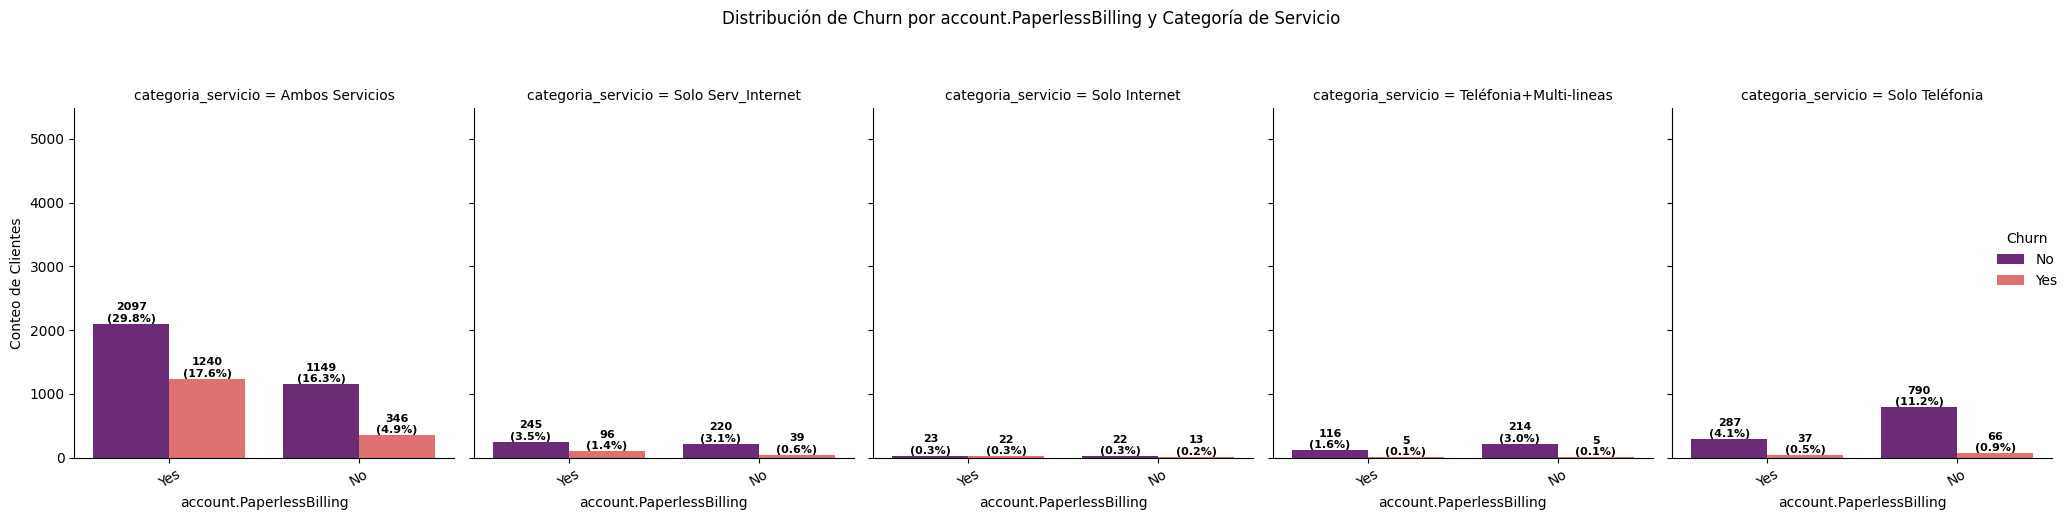

In [48]:
# Lista de columnas demográficas
categoria_comportamiento=['account.Contract',
    'account.PaymentMethod',
    'account.PaperlessBilling']


# Total de registros para calcular porcentajes (usando el df de ejemplo)
total_records = len(df)

# Iteramos sobre cada columna demográfica para crear un gráfico
for col in categoria_comportamiento:
    # Usamos catplot para crear subplots por 'categoria_servicio'
    g = sns.catplot(
        data= df,
        x=col,
        hue='Churn',
        col='categoria_servicio', # Esto crea los subplots
        kind='count',
        palette='magma',
        height=5,
        aspect=0.8
    )

    # Título general para la figura
    g.fig.suptitle(f'Distribución de Churn por {col} y Categoría de Servicio', y=1.03)
    g.set_xticklabels(rotation=30)
    g.set_xlabels(f'{col}')
    g.set_ylabels('Conteo de Clientes')

    # ── Anotaciones de conteo y porcentaje ───────────────────────────
    # Iteramos sobre cada subplot (ax) en la figura
    for ax in g.axes.flat:
        # Iteramos sobre cada barra (patch) en el subplot
        for patch in ax.patches:
            count = int(patch.get_height())
            if count == 0:
                continue
            pct = 100 * count / total_records
            ax.annotate(
                f'{count}\n({pct:.1f}%)',
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center', va='bottom',
                fontsize=8, fontweight='bold'
            )
        # Ajustar límites del eje Y para dar espacio a las etiquetas
        if ax.get_ylim()[1] > 0: # Solo si hay datos
            y_max = ax.get_ylim()[1]
            ax.set_ylim(0, y_max * 1.20)

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para el suptitle
    plt.show()

/tmp/ipython-input-3478537744.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(


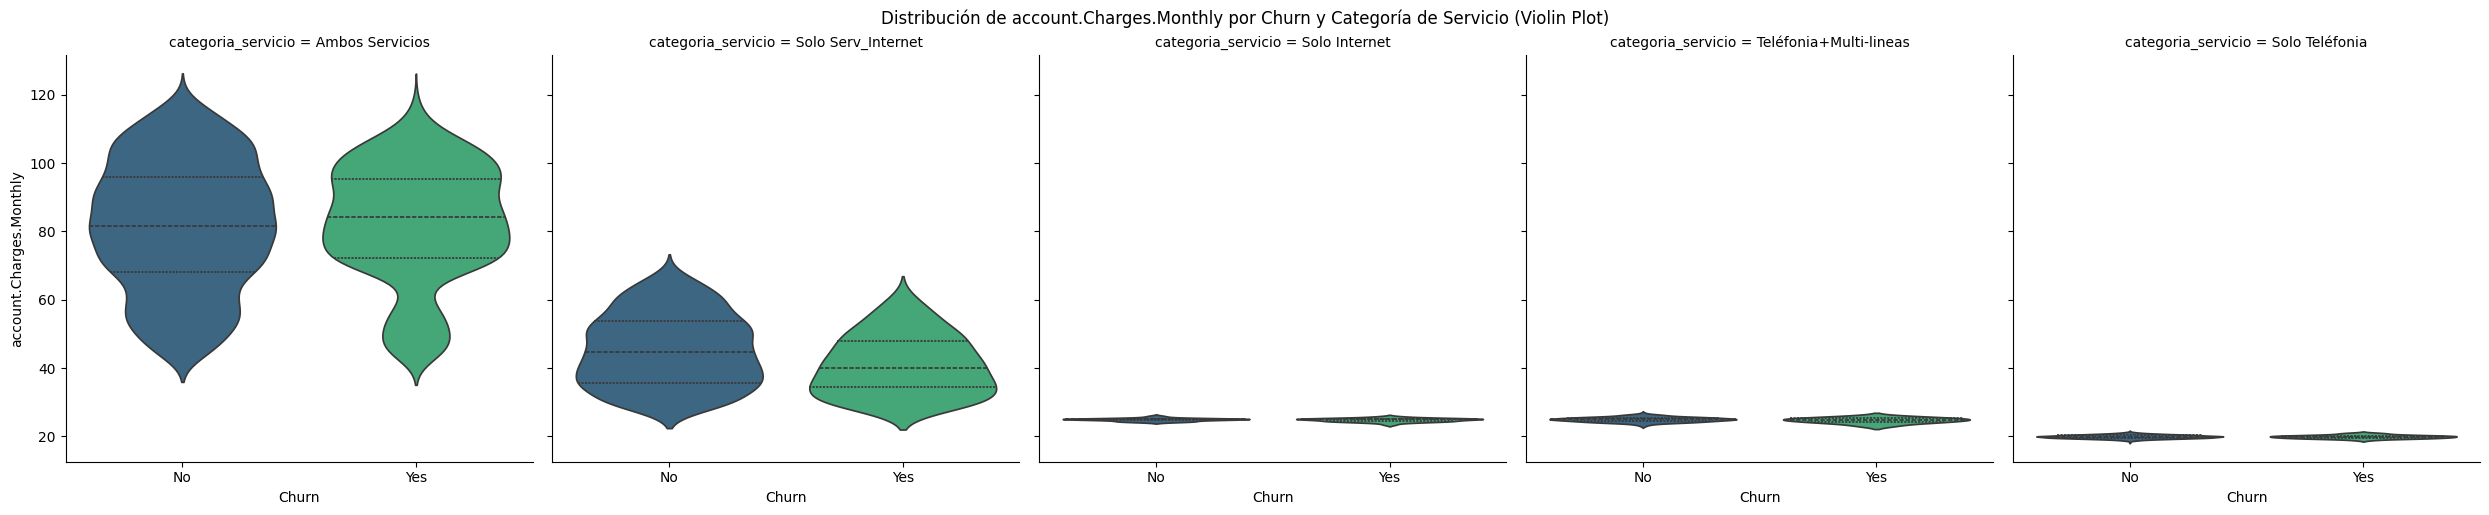

/tmp/ipython-input-3478537744.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(


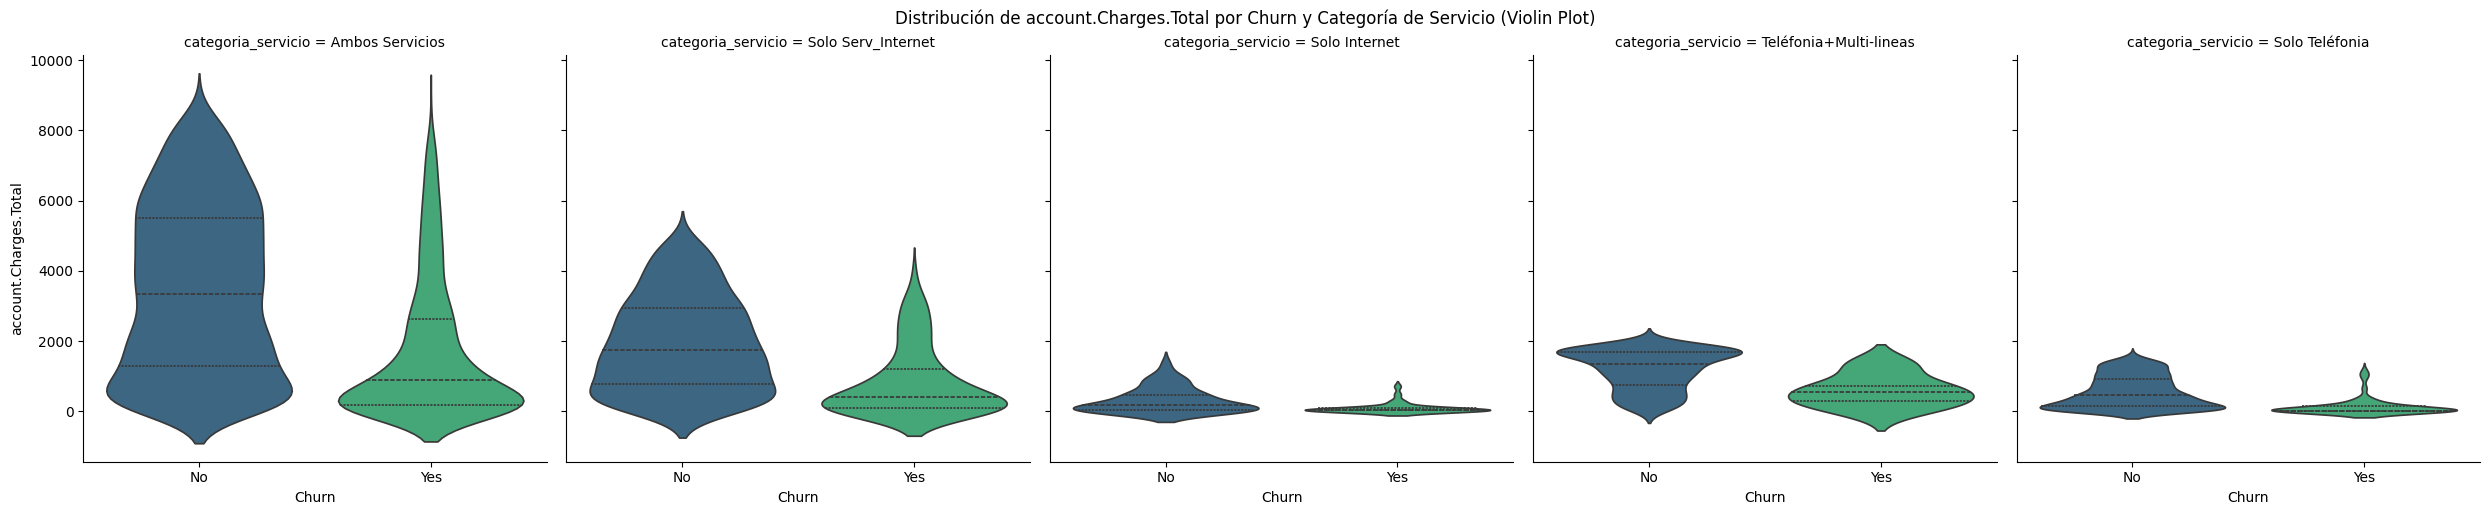

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io



columns_numeric = ['account.Charges.Monthly', 'account.Charges.Total']

for col_num in columns_numeric:
    sns.catplot(
        data=df,
        x='Churn',
        y=col_num,
        col='categoria_servicio',
        kind='violin', # Aquí está el cambio a 'violin'
        palette='viridis',
        inner='quartile' # Muestra las líneas de los cuartiles dentro del violín
    )
    plt.suptitle(f'Distribución de {col_num} por Churn y Categoría de Servicio (Violin Plot)', y=1.02)
    plt.show()